In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [115]:
# Cargar el archivo Excel
df = pd.read_excel(r"C:\Users\marco\Desktop\GitProjects\app_plagio\Excels\logs-exam.xlsx")

# Filtrar las filas donde 'Nombre del evento' coincide con cualquiera de los valores en la lista
df = df[df['Nombre del evento'].isin(['Intento de examen iniciado', 'Intento de examen enviado', 'Intento de examen actualizado'])]

def convertir_hora(texto):
    dato = texto.split()
    horas = dato[1]
    minutos = int(horas[3:5]) * 60
    segundos = int(horas[6:8])
    total = minutos + segundos
    return total
    
df['Hora'] = df['Hora'].apply(convertir_hora)


def sacar_id(texto):
    id ="" 
    if "'" in texto[18:20]:
        id = texto[18:19]
    else:
        id = texto[18:20]
    return int(id)

df['Id'] = df['Descripción'].apply(sacar_id)
df = df.sort_values(by= 'Id')

def editar_descripcion(texto):
    nueva_descripcion = ""
    if "'" in texto[18:20]:
        if texto[52:54] == '10':
            nueva_descripcion += texto[52:54]
        else:
            nueva_descripcion += texto[52:53]
    else: 
        if texto[53:55] == '10':
            nueva_descripcion += texto[53:55]
        else:
            nueva_descripcion += texto[53:54]
    return nueva_descripcion

# Aplica la función solo a las filas donde 'Nombre del evento' es 'Intento de examen actualizado'
df['Descripción'] = df.apply(lambda x: editar_descripcion(x['Descripción']) if x['Nombre del evento'] == 'Intento de examen actualizado' else x['Descripción'], axis=1)

# Actualizar 'Descripción' para ciertos eventos
df.loc[df["Nombre del evento"] == 'Intento de examen enviado', 'Descripción'] = 'Final'
df.loc[df["Nombre del evento"] == 'Intento de examen iniciado', 'Descripción'] = 'Inicio'

# Calcular la columna 'Tiempo' usando la diferencia con la fila anterior
df['Tiempo'] = df['Hora'].shift(1) - df['Hora']

# Ajustar el valor de 'Tiempo' cuando la descripción sea '1'
df.loc[df['Descripción'] == '1', 'Tiempo'] = df['Hora'].shift(1) - df['Hora'].shift(-1) 
df.loc[df['Descripción'] == 'Final', 'Tiempo'] = 0
df.loc[df['Descripción'] == 'Inicio', 'Tiempo'] = 0

df['Tiempo'] = df['Tiempo'].astype(int)

df = df[df['Descripción'] != 'Final']
df = df[df['Descripción'] != 'Inicio']

#Cambiar filas que tiene timpo negativo a 17 (promedio general)
df["Tiempo"] = df["Tiempo"].apply(lambda x: random.randint(16, 19)  if x < 0 else x)

#cambiar de nombre a columnas
df = df.rename(columns={'Nombre completo del usuario':'Usuario','Descripción':'Pregunta'})

df =  df.drop([1615,1613,1617,1600,1598,1596]) 
columna = df.pop('Id')  # Eliminar la columna 'B'
df.insert(0, 'Id', columna)  # Insertar 'B' en la primera posición (índice 0)


# Eliminar columnas no deseadas
df = df.drop(['Hora','Contexto del evento', 'Usuario afectado', 'Dirección IP', 'Origen','Nombre del evento','Componente'], axis=1)

# Mostrar el DataFrame resultante
df 


,Id,Usuario,Pregunta,Tiempo
830,6,William Aguado,6,16
840,6,William Aguado,1,18
832,6,William Aguado,5,19
836,6,William Aguado,3,147
834,6,William Aguado,4,16
...,...,...,...,...
265,56,Manuel Velasquez,9,108
275,56,Manuel Velasquez,4,289
269,56,Manuel Velasquez,7,17
273,56,Manuel Velasquez,5,72


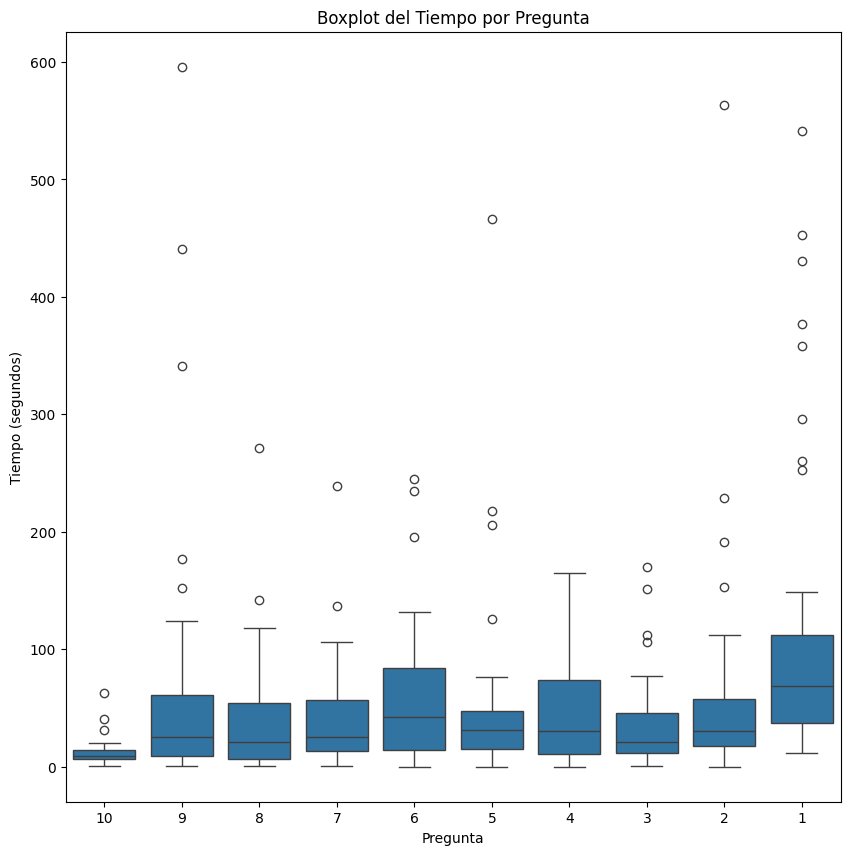

In [48]:
plt.figure(figsize=(10, 10))
sns.boxplot(x="Pregunta", y="Tiempo", data=df)
plt.title("Boxplot del Tiempo por Pregunta")
plt.xlabel("Pregunta")
plt.ylabel("Tiempo (segundos)")
plt.show()

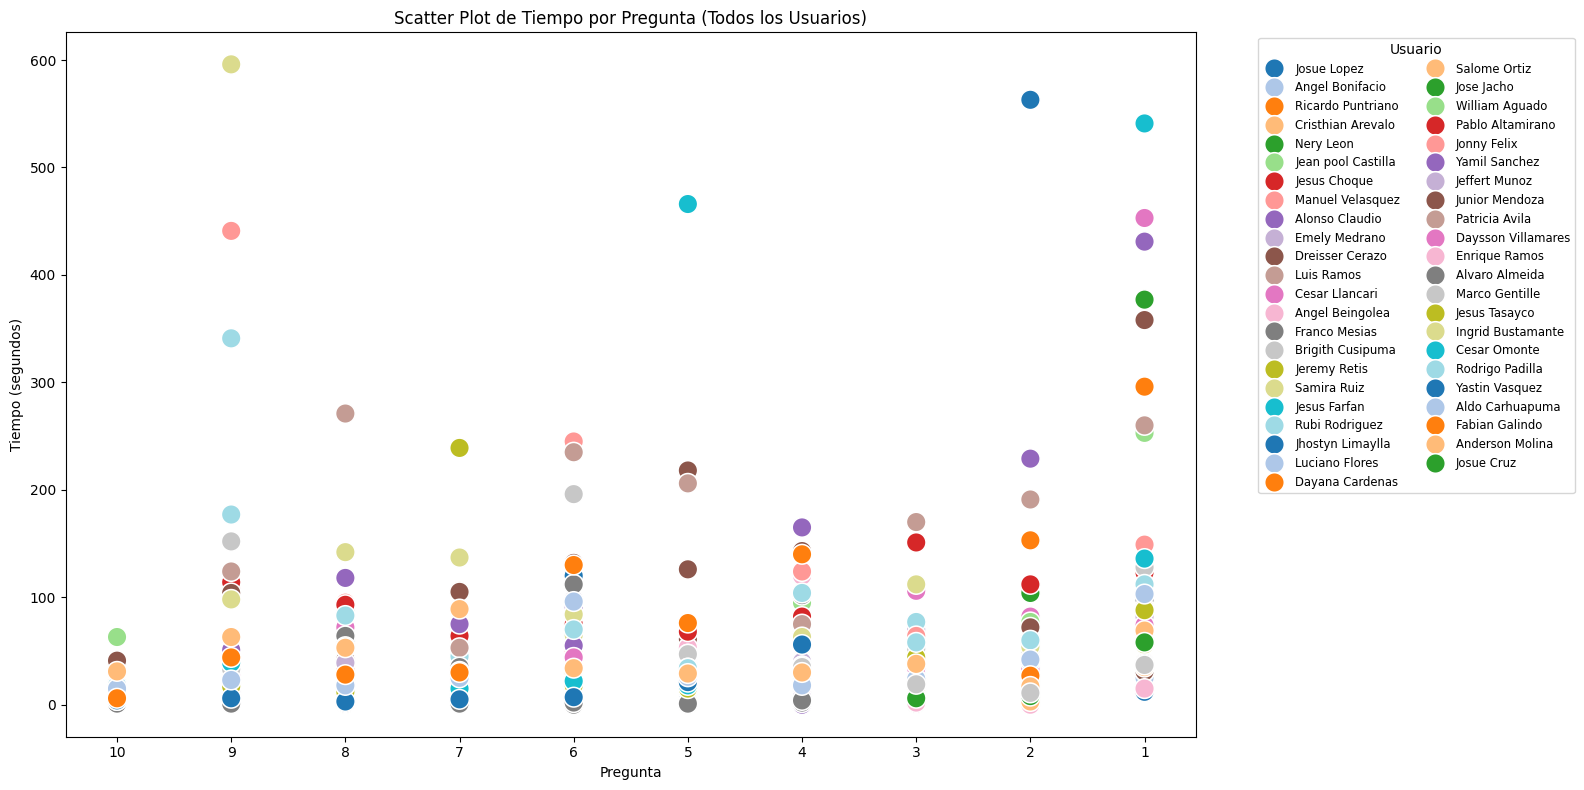

In [49]:
# Ajustaremos el tamaño del gráfico y el tamaño de los puntos para incluir a todos los usuarios de forma legible.
# También organizaremos la leyenda de manera que sea más fácil de leer.

plt.figure(figsize=(16, 8))  # Aumentar el tamaño de la figura
sns.scatterplot(x="Pregunta", y="Tiempo", hue="Usuario", data=df, s=200, palette="tab20")  # Reducir aún más el tamaño de los puntos
plt.title("Scatter Plot de Tiempo por Pregunta (Todos los Usuarios)")
plt.xlabel("Pregunta")
plt.ylabel("Tiempo (segundos)")
plt.legend(title="Usuario", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2, fontsize="small")  # Colocar la leyenda a un lado en dos columnas
plt.tight_layout()
plt.show()

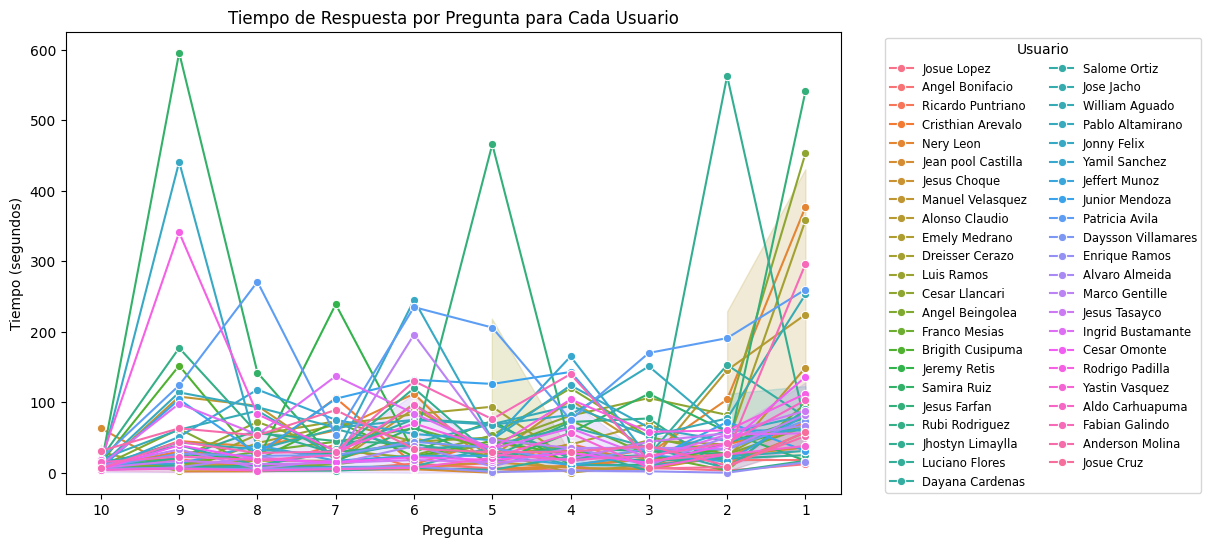

In [50]:
# 3. Gráfico de líneas para cada usuario
plt.figure(figsize=(10, 6))
sns.lineplot(x="Pregunta", y="Tiempo", hue="Usuario", marker="o", data=df)
plt.title("Tiempo de Respuesta por Pregunta para Cada Usuario")
plt.xlabel("Pregunta")
plt.ylabel("Tiempo (segundos)")
plt.legend(title="Usuario", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2, fontsize="small")  # Colocar la leyenda a un lado en dos columnas

plt.show()

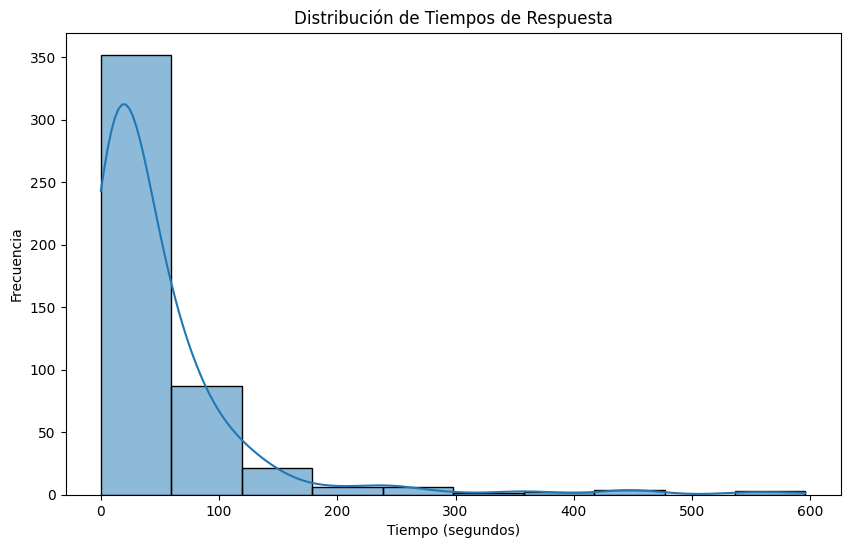

In [51]:
# 4. Histograma de tiempo de respuesta
plt.figure(figsize=(10, 6))
sns.histplot(df["Tiempo"], bins=10, kde=True)
plt.title("Distribución de Tiempos de Respuesta")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Frecuencia")
plt.show()

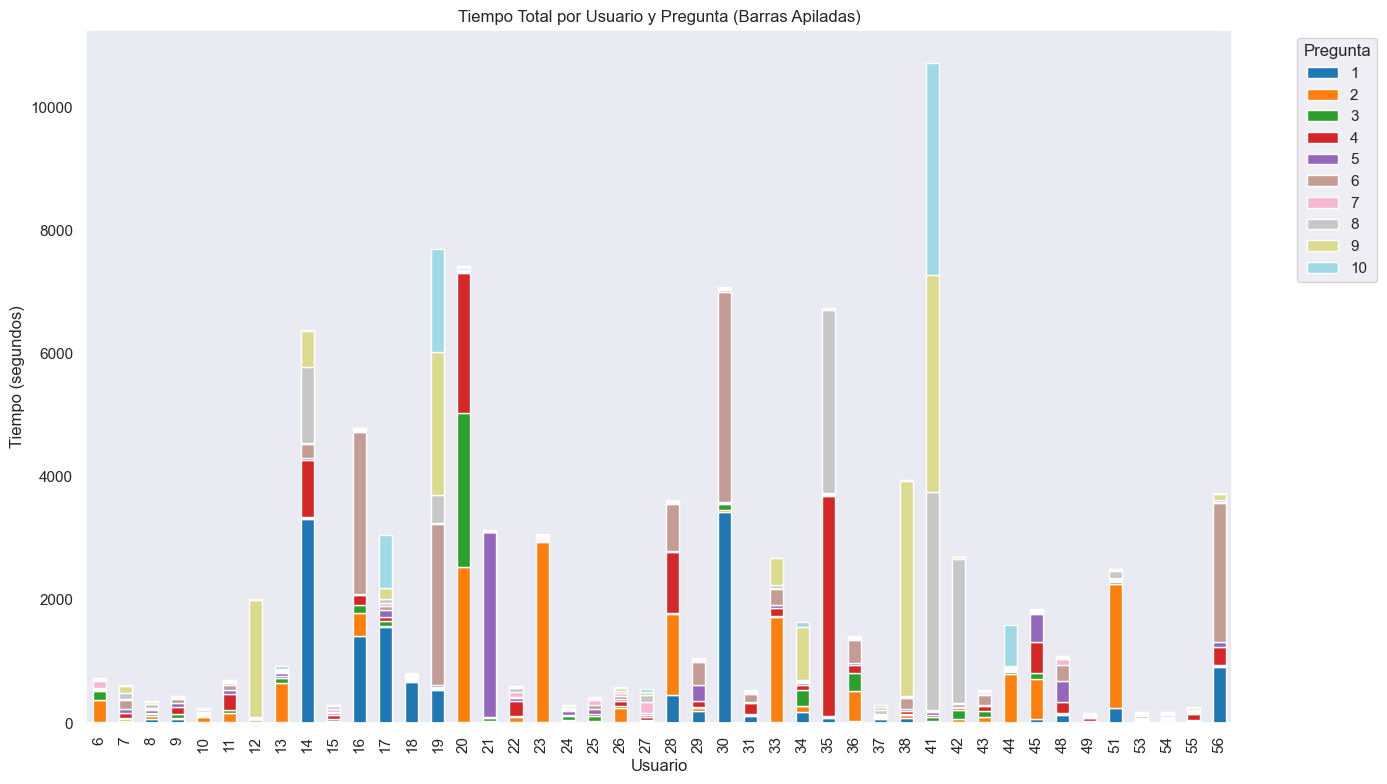

In [112]:
# Asegurarse de que la columna 'Preguntas' esté en formato numérico
df['Pregunta'] = pd.to_numeric(df['Pregunta'], errors='coerce')

# Crear la tabla dinámica
pivot_table_sum = df.pivot_table(values="Tiempo", index="Id", columns="Pregunta", aggfunc="sum")

# Ordenar las columnas de las preguntas numéricamente
pivot_table_sum = pivot_table_sum[sorted(pivot_table_sum.columns)]

# Graficar el gráfico de barras apiladas
pivot_table_sum.plot(kind="bar", stacked=True, figsize=(14, 8), colormap="tab20")
plt.title("Tiempo Total por Usuario y Pregunta (Barras Apiladas)")
plt.xlabel("Usuario")
plt.ylabel("Tiempo (segundos)")
plt.legend(title="Pregunta", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



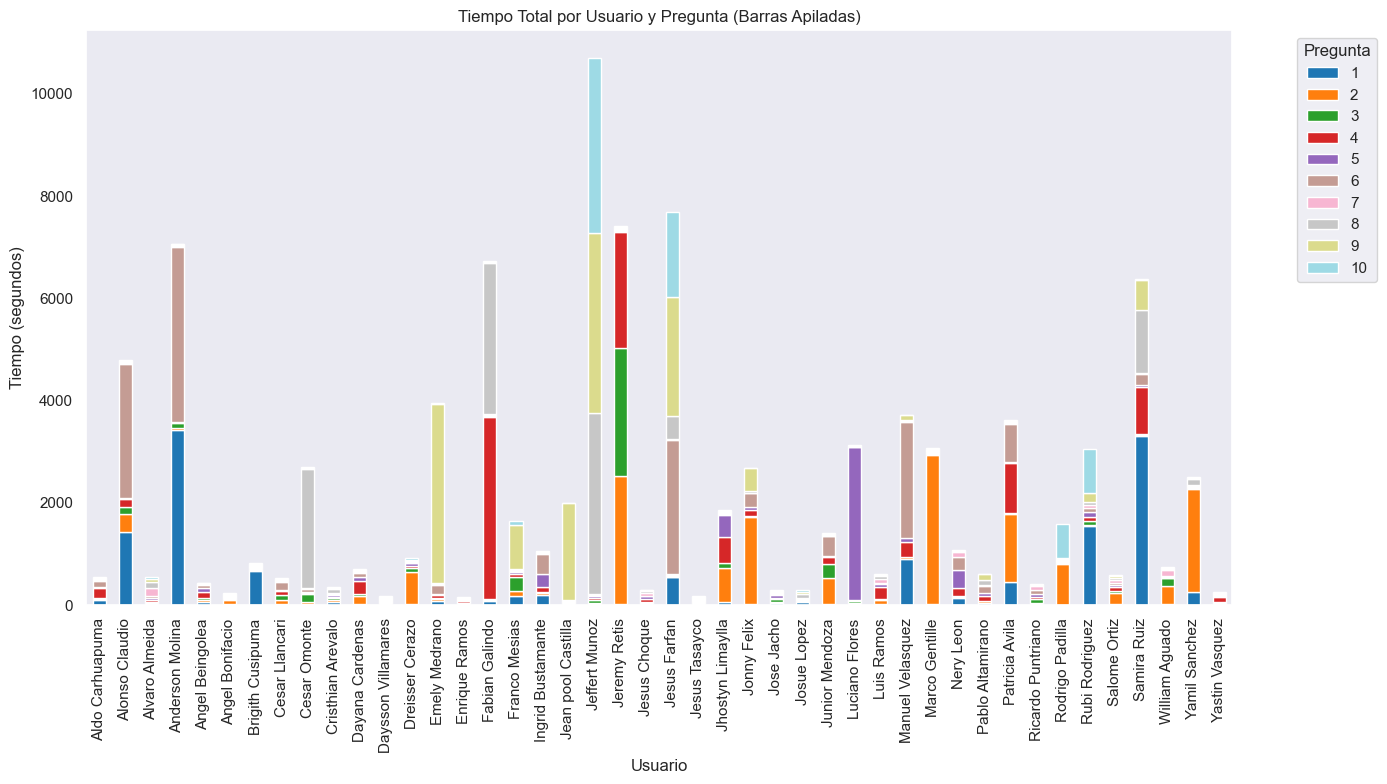

In [113]:
# Asegurarse de que la columna 'Preguntas' esté en formato numérico
df['Pregunta'] = pd.to_numeric(df['Pregunta'], errors='coerce')

# Crear la tabla dinámica
pivot_table_sum = df.pivot_table(values="Tiempo", index="Usuario", columns="Pregunta", aggfunc="sum")

# Ordenar las columnas de las preguntas numéricamente
pivot_table_sum = pivot_table_sum[sorted(pivot_table_sum.columns)]

# Graficar el gráfico de barras apiladas
pivot_table_sum.plot(kind="bar", stacked=True, figsize=(14, 8), colormap="tab20")
plt.title("Tiempo Total por Usuario y Pregunta (Barras Apiladas)")
plt.xlabel("Usuario")
plt.ylabel("Tiempo (segundos)")
plt.legend(title="Pregunta", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



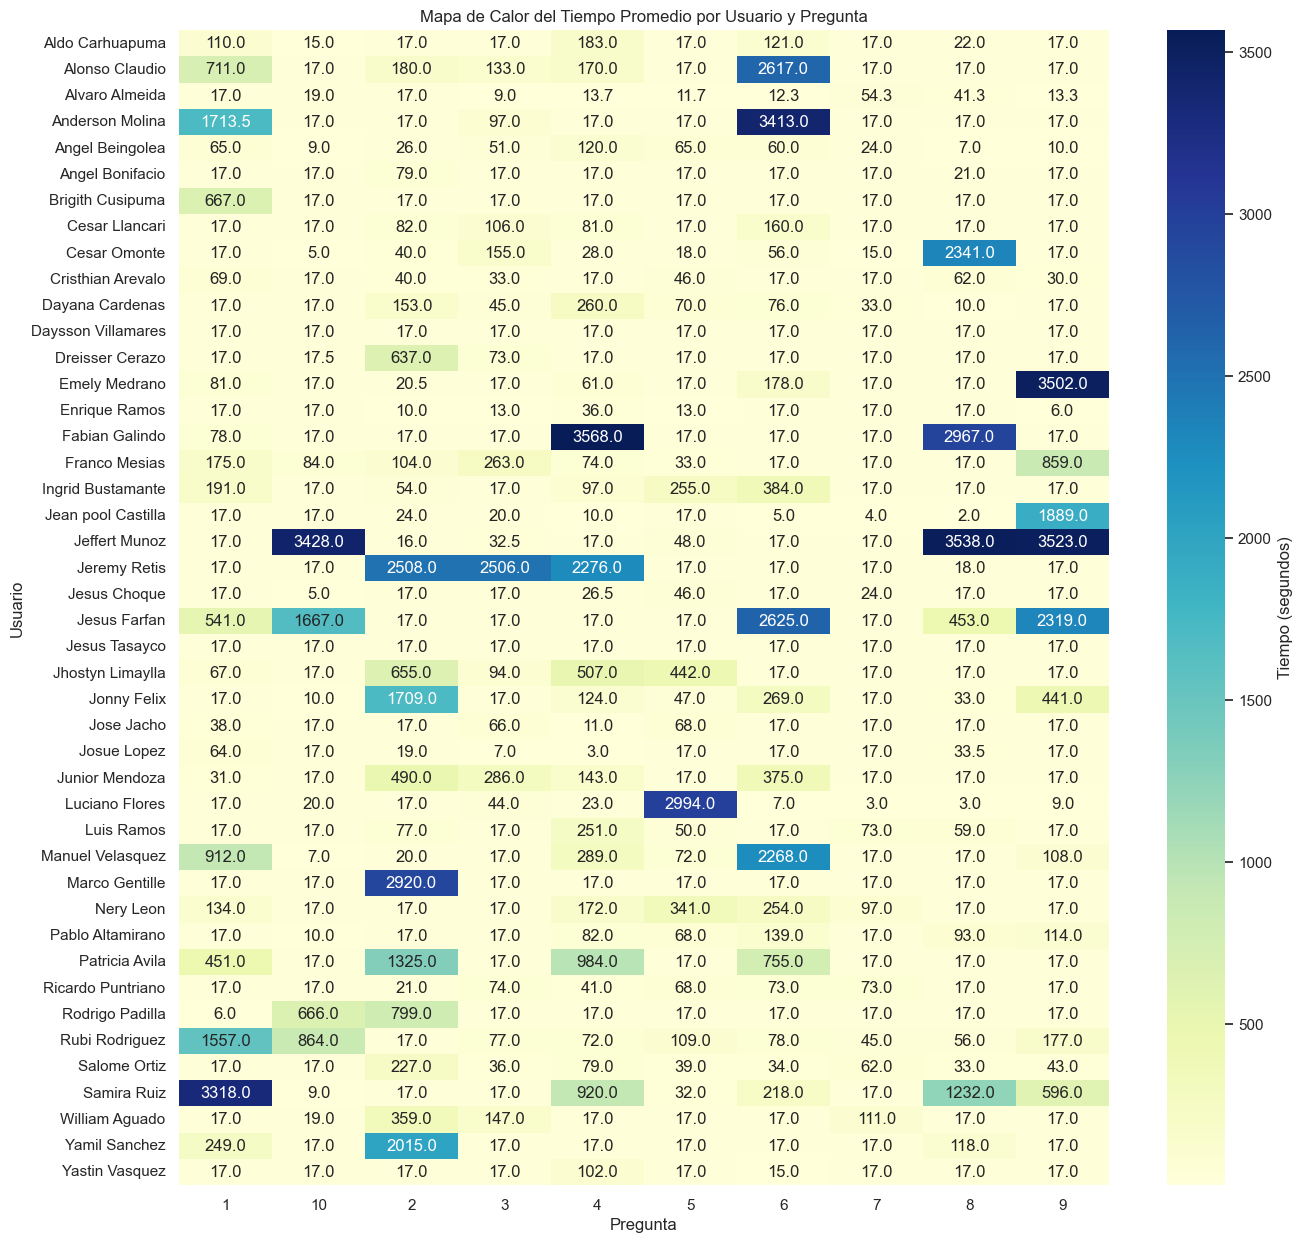

In [104]:

# Calcular el tiempo promedio por cada combinación de usuario y pregunta
pivot_table = df.pivot_table(values="Tiempo", index="Usuario", columns="Pregunta", aggfunc="mean")

# Graficar el heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Tiempo (segundos)'})
plt.title("Mapa de Calor del Tiempo Promedio por Usuario y Pregunta")
plt.xlabel("Pregunta")
plt.ylabel("Usuario")
plt.show()


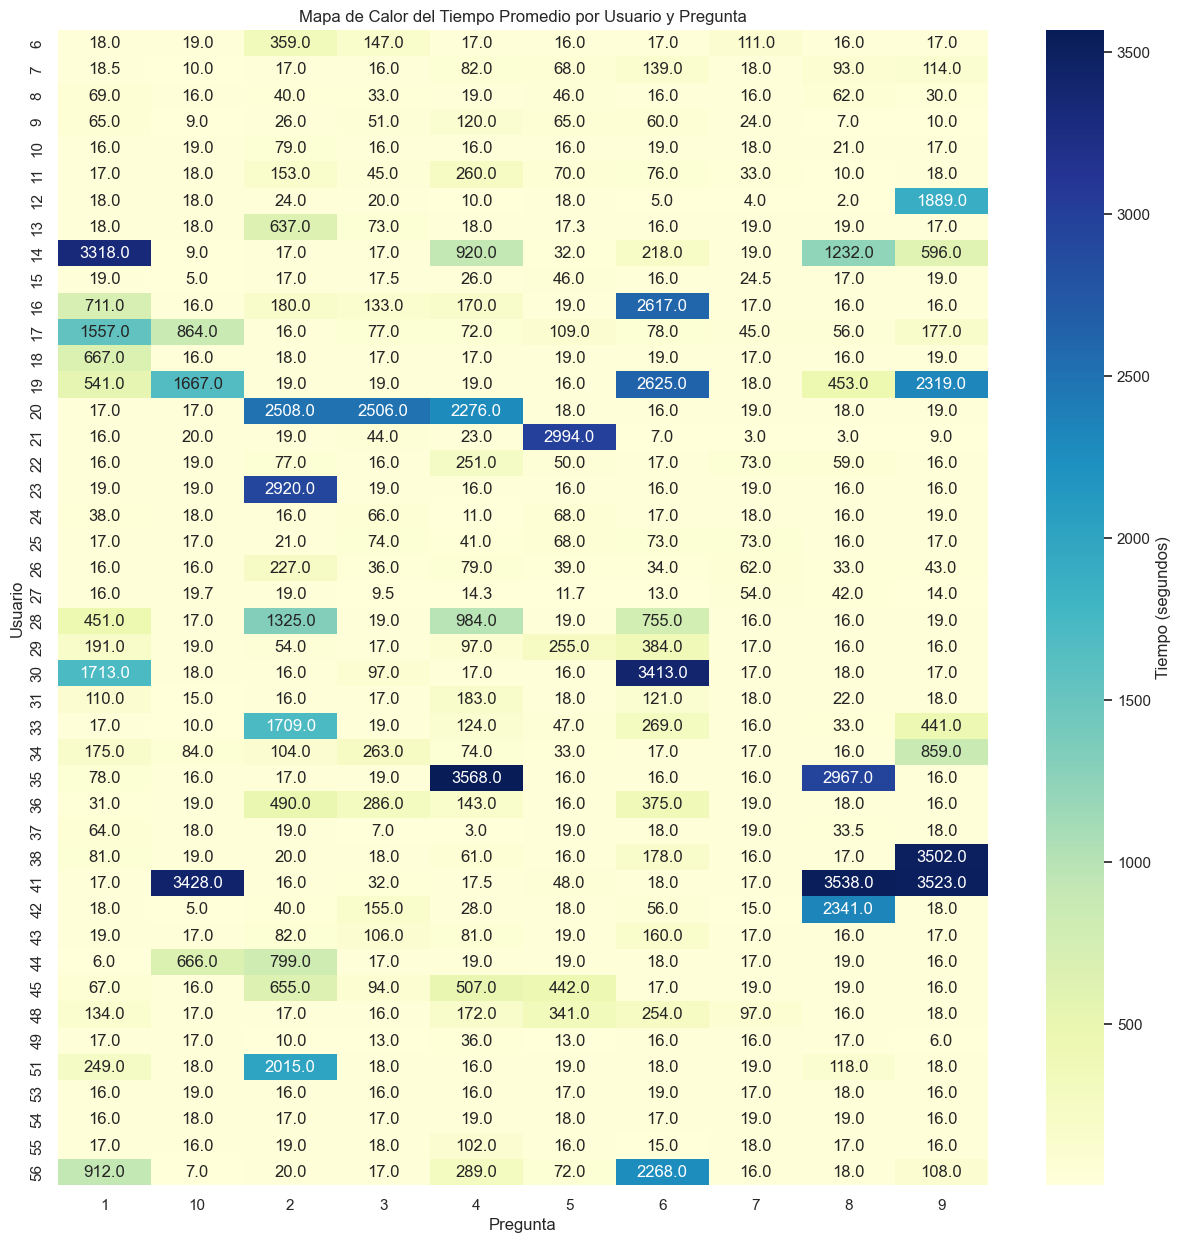

In [110]:

# Calcular el tiempo promedio por cada combinación de usuario y pregunta
pivot_table = df.pivot_table(values="Tiempo", index="Id", columns="Pregunta", aggfunc="mean")

# Graficar el heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Tiempo (segundos)'})
plt.title("Mapa de Calor del Tiempo Promedio por Usuario y Pregunta")
plt.xlabel("Pregunta")
plt.ylabel("Usuario")
plt.show()


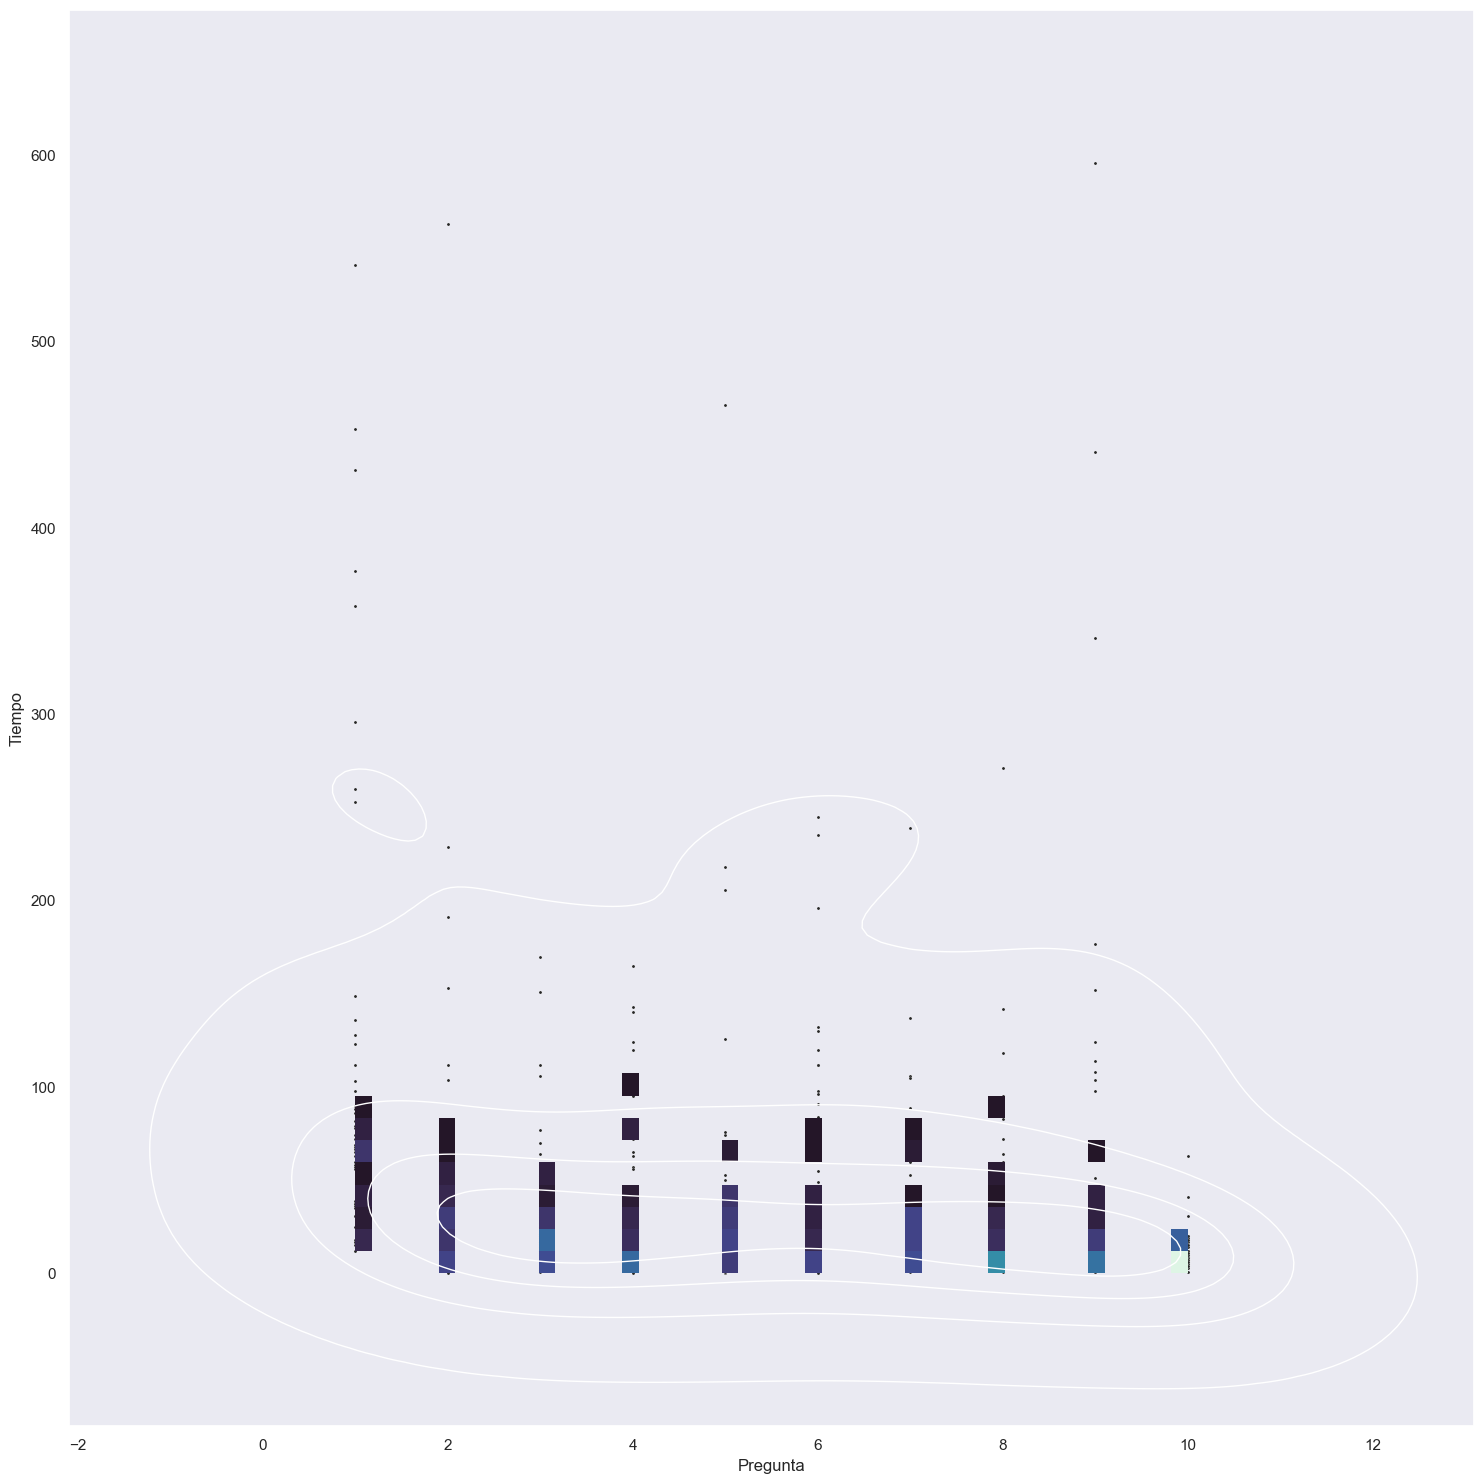

In [69]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tu dataframe es df y tiene las columnas "Tiempo" y "Pregunta"
# Asegúrate de que tus datos estén en formato adecuado para realizar la gráfica
sns.set_theme(style="dark")

# Convertir "Pregunta" a un tipo numérico si es necesario (en caso de ser texto o categorías)
df['Pregunta'] = pd.to_numeric(df['Pregunta'], errors='coerce')

# Extraer las columnas "Tiempo" y "Pregunta"
x = df['Pregunta']
y = df['Tiempo']

# Crear una figura y un eje
f, ax = plt.subplots(figsize=(15, 15))

# Graficar el scatterplot con puntos
sns.scatterplot(x=x, y=y, s=5, color=".15")

# Graficar el histograma bidimensional
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")

# Agregar contornos de densidad
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

# Títulos y etiquetas
plt.xlabel("Pregunta")
plt.ylabel("Tiempo")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

